# Anger Camera SPICE-Integrated Data Reduction Script

Cycle 502 Angle-encoded radiography 7/31 - 8/11 (2023) at CG4B.

### Functions, constants, and definitions

In [1]:
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.signal import find_peaks
from scipy.integrate import simpson

SMALL_SIZE,MEDIUM_SIZE,BIGGER_SIZE = 30,36,42
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rc('axes', titlesize=BIGGER_SIZE)    # actually gets title font size (glitch in matplotlib?)
plt.rcParams.update({'axes.grid':True})

pixels_to_mm = 116./512.  #0.227 mm per pixel in Anger camera
cl = -4.63  #larmor constant
lam = 5.5  #CG4B wavelength
gpa = 31  #MWP and guide gauss per amps

# directories where the raw binary data is stored
beamline_direct = "C:/Users/cg4b/Desktop/Anger_Spice/data/exp_11/"
laptop_direct = "C:/Users/samck/Desktop/exp_11/"
default_direct = laptop_direct  #used in the new_reduce function

def ShowImage(inImage):
    """Plots image in reduction function."""
    fig, ax = plt.subplots(1,1, figsize=(8,6))
    im = ax.imshow(inImage, origin="lower", aspect="auto")
    fig.colorbar(im)
    fig.tight_layout()
    plt.show()

def new_reduce(subscans,print_fnames=False,print_raw=False,print_BGsub=False,\
               print_summed=False,print_ROI=False,ROI_x=(100,400),ROI_y=(100,400),direct=default_direct):
    """Returns the summed, BG corrected, ROI 2d array of counts."""
    
    ROIImages = []  #stores the background corrected region of interest
    
    filenames = [f'{direct}CG4B_{i}/sipm2d.dat' for i in subscans]
    if print_fnames:
        print("Files used:", filenames)

    for indx,filename in enumerate(filenames):
        raw_image = np.fromfile(filename,dtype=np.uint32).reshape(512,512).T
        if print_raw:
            print('***Raw Image***')
            ShowImage(raw_image)

        BG_pixels = raw_image[0:20:,0:20:]
        BG_sum = np.sum(BG_pixels)
        BGperpixel =  float(BG_sum/np.size(BG_pixels))

        BGC_image = raw_image-BGperpixel  #subtracts background
        if print_BGsub:
            print("***BG subtracted image***")
            print("Subscan name: ",filename)
            print("BG per pixel:", BGperpixel)
            ShowImage(BGC_image)
        
        ROI_image = BGC_image[ROI_y[0]:ROI_y[1]:,ROI_x[0]:ROI_x[1]:]
        if print_ROI:
            print("***Region of interest***")
            print("Total counts in ROI: ", np.sum(ROI_image), "\n")
            ShowImage(ROI_image)

        ROIImages.append(ROI_image)

    summedROI = np.sum(ROIImages,axis=0)
    if print_summed:
        print("***Combined image of all subscans***")
        print("Total counts in summed ROI: ", np.sum(summedROI))
        ShowImage(summedROI)
    return summedROI

def ana_run(up,down,plot_pol=True,plot_slice=True,lims=(-1,1)):
    """Returns polarizations from reduced runs."""
    pol = (up-down)/(up+down)
    pol_x,pol_y = np.mean(pol,axis=0),np.mean(pol,axis=1)
    if plot_pol:
        plt.figure(figsize=(8,6))
        plt.imshow(pol,origin='lower',vmin=lims[0],vmax=lims[1])
        plt.colorbar()
        plt.tight_layout()
        plt.show()
    if plot_slice:
        plt.figure(figsize=(8,5))
        plt.plot(pol_x)
        plt.plot(pol_y)
        plt.ylim(lims)
        plt.tight_layout()
        plt.grid()
        plt.show()
    return pol,pol_x,pol_y
    
def reduce_scan(istart,currents,ROI_x,ROI_y,ssn=10,plot_pol=False,plot_slice=False,plot_all=True,plot_each=False):
    """Returns polarizations and intensities from an AER scan."""
    ints,intx,inty = [],[],[]
    pols,pxs,pys = [],[],[]
    for indx,c in enumerate(currents):
        subscans = range(istart+indx*ssn*2,istart+ssn+indx*ssn*2)
        ints.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False))
        intx.append(np.sum(ints[-1],axis=0))
        inty.append(np.sum(ints[-1],axis=1))
        subscans = range(istart+ssn+indx*ssn*2,istart+ssn*2+indx*ssn*2)
        ints.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False))
        intx.append(np.sum(ints[-1],axis=0))
        inty.append(np.sum(ints[-1],axis=1))
        p,px,py = ana_run(ints[-2],ints[-1],plot_pol=plot_pol,plot_slice=plot_slice)
        pols.append(p)
        pxs.append(px)
        pys.append(py)
    if plot_all:
        fig = plt.figure(figsize=(8,5))  #prints all polarizations
        for indx,p in enumerate(pxs):
            plt.plot(p,label=f'{round(currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.tight_layout()
        plt.show()
    if plot_each:
        for indx,p in enumerate(pxs):
            fig = plt.figure(figsize=(8,5))  #prints each polarization separately
            plt.plot(p,label=f'{round(currents[indx],3)}')
            plt.grid()
            plt.legend()
            plt.ylim((-1,1))
            plt.tight_layout()
            plt.show()
        
    return np.array(ints),np.array(intx),np.array(inty),np.array(pols),np.array(pxs),np.array(pys)

In [23]:
laptop_output = 'C:/Users/samck/Desktop/spliced/'
default_output = laptop_output

spice_laptop_direct = 'C:/Users/samck/Desktop/exp_11/Datafiles/'
default_spice_direct = spice_laptop_direct

def get_scan(number):
    """Returns the data file scan number in Spice format."""
    const = 3
    if (number > 999):    #no leading zeros
        zeros = 0
    else:
        if (number == 0):
            zeros = const
        else:
            zeros = const - int(np.floor(np.log10(number)))
    return '0'*zeros + str(number)

default_order = ['prisms','guide','sample','nu_pre','nu_post','sample','a_tran','a_rot','mtrans','mfocus','s2','a2']
default_dict = {i[1]:i[0] for i in enumerate(default_order)}

useful_order = default_order[:7]
useful_dict = {i[1]:i[0] for i in enumerate(useful_order)}

def data_loader(names,path=default_spice_direct,dest=default_output,reorder=False):
    """Returns the list [scan number, scan date, scan time start, user input scan titles, matrix of data from scan].
    Cuts out all of the worthless parameters that we can't remove from SPICE for some reason."""
    scan_nums,dates,times,scan_titles,parms,data,data_out = [],[],[],[],[],[],[]  #This is a real cat's buffet
    for i in range(len(names)):
        file = open(path + names[i])
        lines = file.readlines()
        lines = [i.replace('\n','') for i in lines]  #removes new line characters
        file.close()
        
        scan_nums.append(lines[0][2::])  #line number determined by Spice format
        scan_nums[i] = scan_nums[i].split(' = ',)[1]
        dates.append(lines[1][2::])
        dates[i] = dates[i].split(' = ',)[1]
        times.append(lines[2][2::])
        times[i] = times[i].split(' = ',)[1]
        scan_titles.append(lines[10][2::])
        scan_titles[i] = scan_titles[i].split(' = ',)[1]
        parms.append(lines[24][7::].split())

        data.append([j.split()[1::] for j in lines[25::] if (j[0] != '#')])  #assigns the data
        data[i] = [[float(data[i][j][k]) for j in range(len(data[i]))] for k in range(len(data[i][0]))]  #converts to float
        data[i] = [list(j) for j in zip(*data[i])]    #transposes table
        
        if (reorder and (parms[i] != default_order)):  #rearranges the columns to default_order
            swap_i = []    #columns to swap
            for j in range(len(parms[i])):
                swap_i.append([j, default_dict[parms[i][j]]])

            swaped_data = [ [0]*len(data[i][0]) for _ in range(len(data[i]))]  #matrix to hold swaped values
            for j in range(len(data[i])):    #slow swapping method, may need some work...
                for k in range(len(data[i][j])):
                    for m in range(len(swap_i)):
                        if (swap_i[m][1] == k):
                            swaped_data[j][k] = data[i][j][m]
                            parms[i][m] = default_order[swap_i[m][0]]    
            data[i] = swaped_data
            
        try: data_out.append(np.array(data[i][0])[:len(useful_order)])  #list of numpy arrays
        except: 
            data_out.append([])
            print(f"Error with scan {scan_nums[i]}!")
                
    if parms[0] == parms[-1]: parms_out = parms[0][:len(useful_order)]  #assumes parameter names are unchanged
    else: 
        parms_out = [parms[i][:len(useful_order)] for i in range(len(parms))]
        print('Parameter list changed!')
    try: data_out = np.array(data_out)
    except: print('Non-homogeneous data: unable to convert to numpy array!')
    
    return scan_nums,dates,times,scan_titles,parms_out,data_out

In [3]:
def my_cos(x,amp,freq,phase):
    return amp*np.cos(freq*(x-.5)+phase)

def my_gauss(x,amp,av,sig):
    return amp*np.exp(-((x-av)/sig)**2/2)

def my_lorz(x,av,gamma,shim):
    return gamma/np.pi/((x-av)**2+gamma**2)

def get_fit(pols,errs,cg_cs_fine,ini_guess=[.1,210,0],\
             plot=True,indxs=(50,55),p_sen=.5):
    """Returns the polarization fitted from phase scan."""
    fitted = []
    ferrs = []
    fig = plt.figure(figsize=(8,6))
    phase = ini_guess[-1]  #intial phase guess
    for indx in range(len(pols[0,:])):
        points = pols[:,indx]
        point_errs = errs[:,indx]
        
        lb,ub = (0,ini_guess[1]-5,phase-p_sen),(1,ini_guess[1]+5,phase+p_sen)  #continuity of fitted phase

        guess=[min(np.max(points),.99),ini_guess[1],phase]
        parms,err = curve_fit(my_cos,cg_cs,points,p0=guess,bounds=(lb,ub),sigma=point_errs)
        fitted.append(parms)
        ferrs.append(np.sqrt(np.diag(err)))
        
        if indxs[0] < indx < indxs[1]:
            plt.plot(cg_cs,points,'o',color=f'C{indx%8}',label=f'{indx}')
            plt.plot(cg_cs_fine,my_cos(cg_cs_fine,*parms),color=f'C{indx%8}')
            if plot: print(f'amp,freq,phase = {np.round(parms,3)}')
        phase = parms[-1]  #continuity of fitted phase

    plt.legend()
    plt.grid()
    if plot: plt.show()
    else: plt.close()
    
    return np.array(fitted),np.array(ferrs)

def trad(empty,sample,plot=True):
    """Returns traditional radiograph."""
    trad1 = np.sum(empty,axis=0)
    trad2 = np.sum(sample,axis=0)
    if plot:
        fig = plt.figure(figsize=(8,4))
        plt.title('Traditional radiograph')
        plt.plot(trad1,label='empty')
        plt.plot(trad2,label='sample')
        plt.legend()
        plt.grid()
        plt.show()
    return trad2/trad1  #normalized radiograph

def barber(e,s,title,cg_cs,vmin=-1,vmax=1):
    """Makes barber plot of the phase scan."""
    fig,ax = plt.subplots(1,2,figsize=(14,6))
    
    im1 = ax[0].imshow(e,origin='lower',vmin=vmin,vmax=vmax,aspect='auto',interpolation='bilinear')
    ax[0].set_title('Empty')
    ax[0].yaxis.set_ticks(range(0,9,4))
    ax[0].yaxis.set_ticks(range(0,9,4))
    #ax[0].yaxis.set_ticklabels(cg_cs[::4])
    ax[0].yaxis.set_ticklabels([r'0',r'$\pi$',r'$2 \pi$'])
    ax[0].xaxis.set_ticks([0,65,129])
    ax[0].xaxis.set_ticklabels([r'-15',r'0',r'15'])
    
    im2 = ax[1].imshow(s,origin='lower',vmin=vmin,vmax=vmax,aspect='auto',interpolation='bilinear')
    ax[1].set_title('Grating')
    ax[1].yaxis.set_ticks(range(0,9,4))
    #ax[1].yaxis.set_ticklabels(cg_cs[::4])
    ax[1].yaxis.set_ticklabels([r'0',r'$\pi$',r'$2 \pi$'])
    ax[1].xaxis.set_ticks([0,65,129])
    ax[1].xaxis.set_ticklabels([r'-15',r'0',r'15'])
    
    cbar_ax = fig.add_axes([0.91, 0.2, 0.015, 0.6])   #left, bottom, width, height
    fig.colorbar(im2, cax=cbar_ax, aspect=1)

    fig.add_subplot(111, frameon=False)    #adds big bounding plot space
    plt.title(f'{title}',pad=50)
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel('$x$ [mm]', labelpad=25)
    plt.ylabel('Phase', labelpad=0)
    
    plt.show()

def compare(e,err_e,s,err_s,plot_freq=False,plot_norm=False,plot_diff=True):
    """Plots the fitted parameters of blank and sample."""
    fig,ax = plt.subplots(1,2,figsize=(12,5))
    ax[0].set_title('Fiited amplitude')
    ax[0].plot(e[:,0],'.',label='empty',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    ax[0].errorbar(range(len(e[:,0])),e[:,0],err_e[:,0],ls='none',zorder=5,color='C0')
    ax[0].plot(s[:,0],'.',label='sample',color='C1',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    ax[0].errorbar(range(len(s[:,0])),s[:,0],err_s[:,0],ls='none',zorder=5,color='C1')
    dark = s[:,0]/e[:,0]
    if plot_norm: ax[0].plot(dark,label='Normed',color='C2')
    ax[0].set_ylim((0,1))  #should be polarization...
    ax[0].legend()
    ax[0].grid()
    
    dark_err = dark*np.sqrt((err_e[:,0]/e[:,0])**2 + (err_s[:,0]/s[:,0])**2)
    
    ax[1].set_title('Fitted phase')
    ax[1].plot(e[:,2],'.',label='empty',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    ax[1].errorbar(range(len(e[:,2])),e[:,2],err_e[:,2],ls='none',zorder=5,color='C0')
    ax[1].plot(s[:,2],'.',label='sample',color='C1',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    ax[1].errorbar(range(len(s[:,2])),e[:,2],err_s[:,2],ls='none',zorder=5,color='C1')
    phase = s[:,2]-e[:,2]
    if plot_diff: ax[1].plot(phase,label='Diff',color='C2')
    ax[1].legend()
    ax[1].grid()
    plt.show()
    
    phase_err = err_e[:,2] + err_s[:,2]
    
    if plot_freq:
        fig = plt.figure(figsize=(8,6))
        plt.title('Fitted frequency')
        plt.plot(e[:,1],label='empty')
        plt.plot(s[:,1],label='sample')
        plt.legend()
        plt.grid()
        plt.show()
    return dark,dark_err,phase,phase_err

def triptych(trad,trad_err,dark,dark_err,phase,phase_err,rng=(30,100),title=''):
    """Plots dark field,phase,and trad."""
    fig, ax = plt.subplots(figsize=(8,5))
    plt.title(title)
    plt.plot(trad[rng[0]:rng[-1]],label='Trad.',color='C0',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    plt.errorbar(range(len(trad[rng[0]:rng[-1]])),trad[rng[0]:rng[-1]],trad_err[rng[0]:rng[-1]],ls='none',zorder=5,color='C0')
                 
    plt.plot(dark[rng[0]:rng[-1]],label='Amp.',color='C1',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    plt.errorbar(range(len(dark[rng[0]:rng[-1]])),dark[rng[0]:rng[-1]],dark_err[rng[0]:rng[-1]],ls='none',zorder=5,color='C1')
                 
    plt.plot(phase[rng[0]:rng[-1]],label='Phase',color='C2',ms=7.5,zorder=5,ls='-',linewidth=2.5)
    plt.errorbar(range(len(dark[rng[0]:rng[-1]])),phase[rng[0]:rng[-1]],phase_err[rng[0]:rng[-1]],ls='none',zorder=5,color='C2')
                 
    ax.xaxis.set_ticks([0,18,35,53,69])
    ax.xaxis.set_ticklabels([r'-8',r'-4',r'0',r'4',r'8'])
    plt.xlabel('$x$ [mm]', labelpad=0)
    plt.ylabel('$T(x)$', labelpad=0)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),handlelength=1)
    plt.grid()
    plt.show()

def get_pol_errors(int_list,plot=False):
    """Returns polarization error."""
    ups = int_list[::2]
    dns = int_list[1::2]
    result = []
    for u,d in zip(ups,dns):
        result.append(2*np.sqrt(2)/(u+d)**2*np.sqrt(u**2*d+u*d**2))
    if plot:
        plt.imshow(result,origin='lower',aspect='auto')
        plt.colorbar()
        plt.show()
    return np.nan_to_num(np.array(result),nan=.5)

def get_trad_error(empty_ints,sample_ints,plot=False):
    """Returns intensity error summed over phase scan."""
    empty = np.sum(empty_ints,axis=0)
    sample = np.sum(sample_ints,axis=0)
    #plt.plot(sample/empty)
    result = sample/empty*np.sqrt(1/empty+1/sample)
    
    if plot:
        plt.plot(result)
        plt.grid()
        plt.show()
    return np.nan_to_num(result,nan=np.max(result)*10)

### Experimental Data Analysis
***

#### 7/31 Alignment and anger camera testing

Still need to include saving time for anger camera. Otherwise some data gets deleted. Hopefully the saving time doesn't scale with the number of counts (didn't with the old script).
Looks like won't get done tonight... There's an issue with the SpICE-python bridge

Files used: ['C:/Users/samck/Desktop/exp_11/CG4B_41/sipm2d.dat']
***Raw Image***


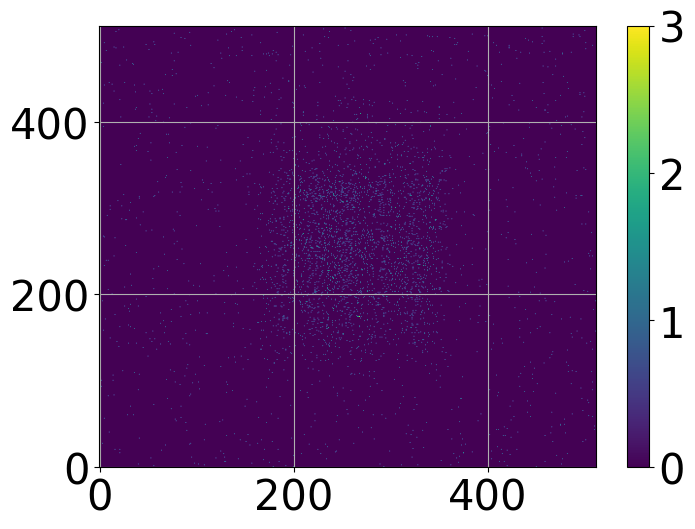

***BG subtracted image***
Subscan name:  C:/Users/samck/Desktop/exp_11/CG4B_41/sipm2d.dat
BG per pixel: 0.0


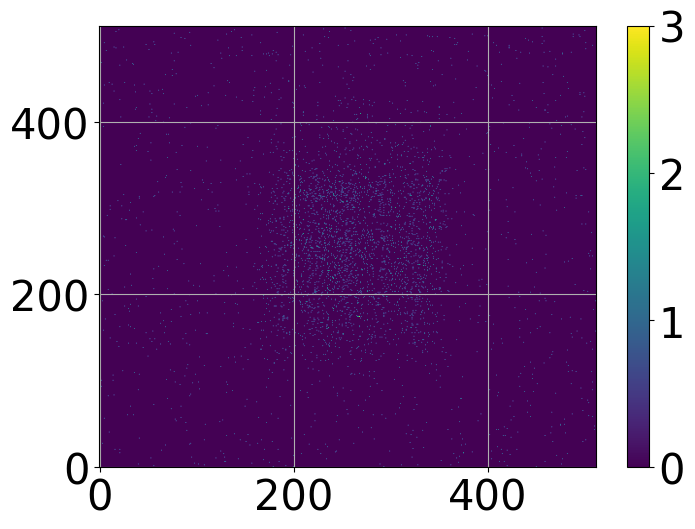

***Region of interest***
Total counts in ROI:  3001.0 



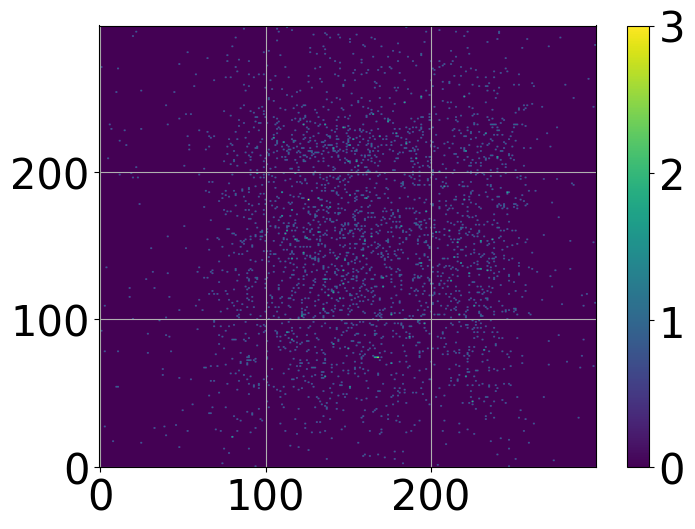

***Combined image of all subscans***
Total counts in summed ROI:  3001.0


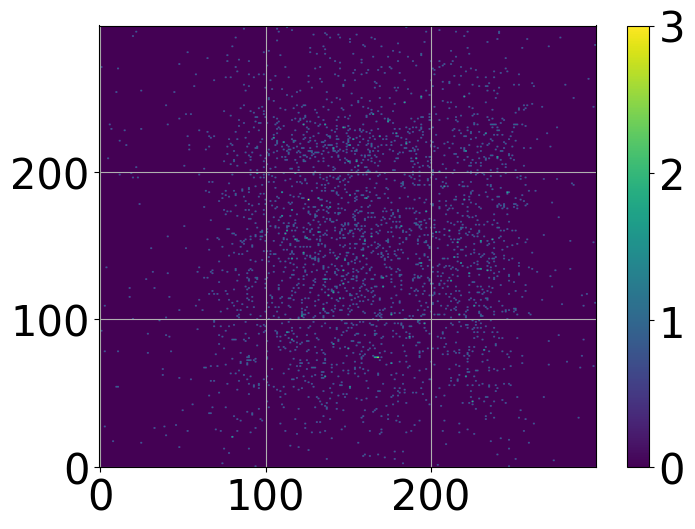

Files used: ['C:/Users/samck/Desktop/exp_11/CG4B_42/sipm2d.dat']
***Raw Image***


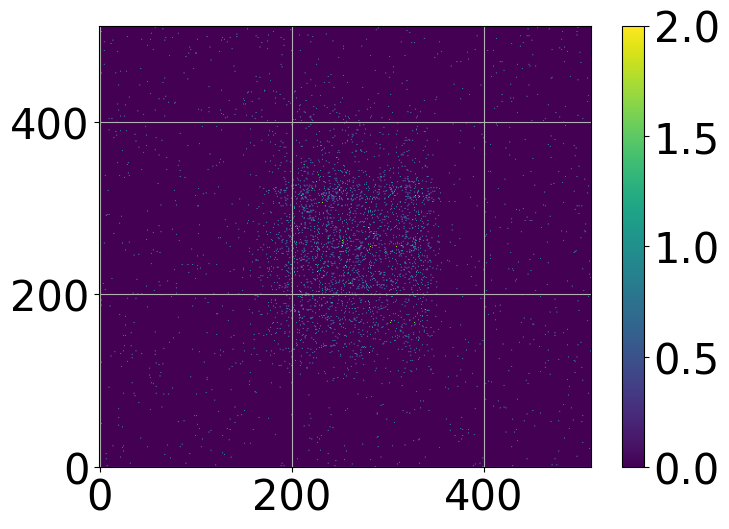

***BG subtracted image***
Subscan name:  C:/Users/samck/Desktop/exp_11/CG4B_42/sipm2d.dat
BG per pixel: 0.0075


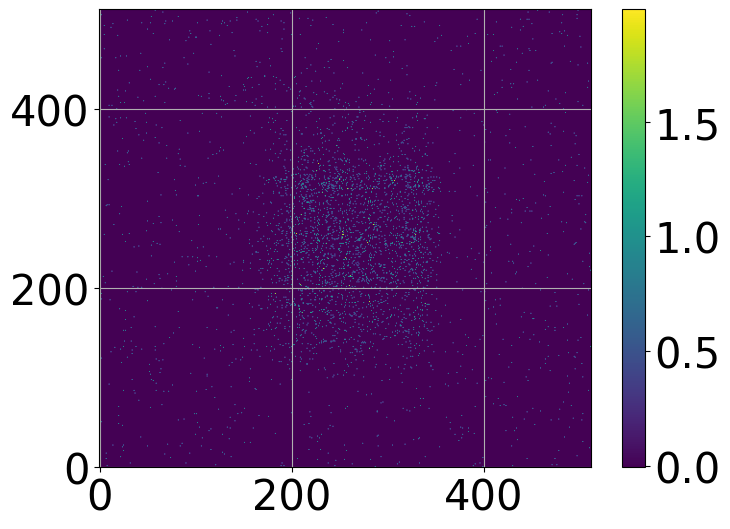

***Region of interest***
Total counts in ROI:  2237.0 



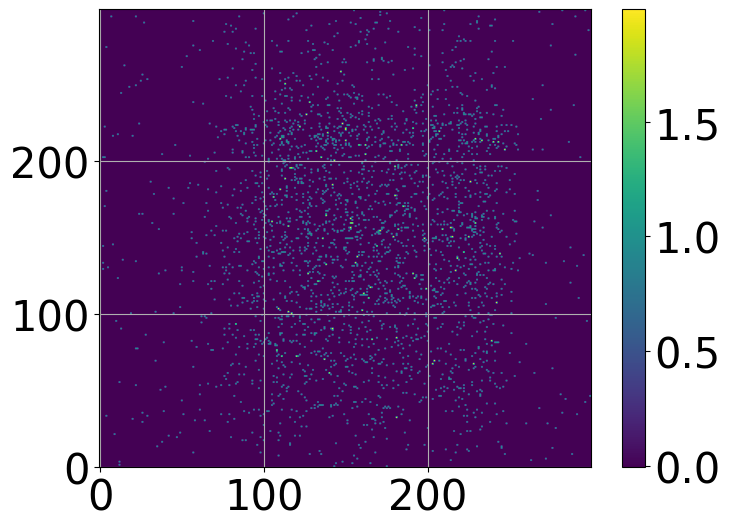

***Combined image of all subscans***
Total counts in summed ROI:  2237.0000000000005


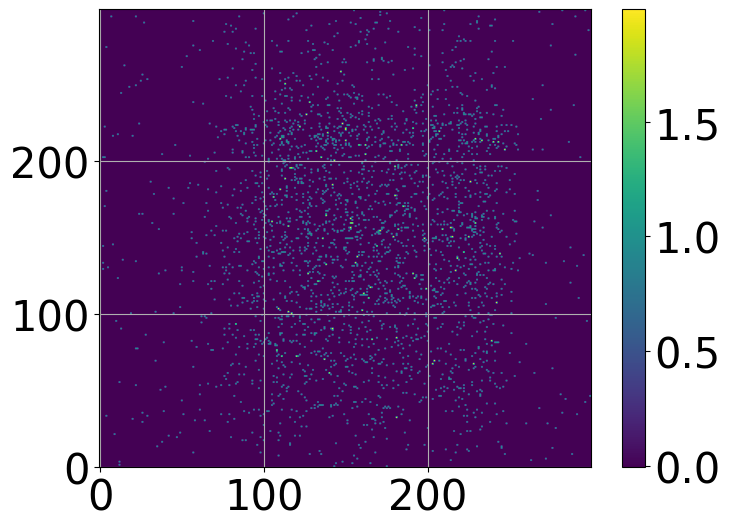

In [21]:
run_nums = [41,42]
file_list = ["/CG4B_exp0011_scan" + get_scan(i) + ".dat" for i in run_nums]
*_,parms,data = data_loader(file_list,reorder=True)

r_x = (100,400)
r_y = (100,400)
for i in run_nums:
    _ =  new_reduce([i],print_fnames=True,print_raw=True,print_BGsub=True,print_summed=True,print_ROI=True,ROI_x=r_x,ROI_y=r_y)

In [22]:
print(parms,data)

['prisms', 'guide', 'sample', 'nu_pre', 'nu_post', 'sample', 'a_tran'] [[ 1.   0.5  0.   5.  -5.   0.   9. ]
 [ 1.   0.5  0.   5.  -5.   0.  10. ]]


#### 8/1 Aligning the s-bender

In [ ]:
s_trans = []
pos = np.linspace(-10,10,21)
beg = 25

for indx,i in enumerate(pos,start=beg):
    s_trans.append(np.sum(new_reduce([indx],print_raw=False,print_ROI=False,ROI_x=r_x,ROI_y=r_y)))
plt.plot(pos,s_trans);

### Overnight 5/27

In [ ]:
phase_currents = np.linspace(1,1.03,9)

In [ ]:
start = 23 #2.5 amps
end = 40

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,9)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,9)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=.1,vmin=-.1)
    plt.colorbar()
    plt.show()"""
for i in oneD_pol:
    plt.plot(i)
    plt.grid()
    plt.show()

In [ ]:
start = 41 #2.8 amps
end = start+17

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,9)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,9)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=.1,vmin=-.1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
    plt.grid()
    plt.legend()
plt.show()

In [ ]:
start = 59 #3.12 amps
end = start+17

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,9)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,9)])

print(np.shape(pol))

for i in pol:
    plt.imshow(i,origin='lower',vmax=.1,vmin=-.1)
    plt.colorbar()
    plt.show()
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
    plt.grid()
    plt.legend()
plt.show()

In [ ]:
start = 77 #3.4 amps
end = start+17

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,9)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,9)])

print(np.shape(pol))

for i in pol:
    plt.imshow(i,origin='lower',vmax=.5,vmin=-.5)
    plt.colorbar()
    plt.show()
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
    plt.grid()
    plt.legend()
plt.show()

### May 28 Day Scan

#### Finding ROI and bining

In [ ]:
#phase_currents = np.linspace(1,1.03,8)  #last nutator flip not working
phase_currents_fine = np.linspace(phase_currents[0],phase_currents[-1],200)

In [ ]:
run_temp,_ = reduce_data(185,185,print_raw=True,print_ROI=True,print_summed=False)
run_temp2,_ = reduce_data(186,186,print_raw=True,print_ROI=True,print_summed=False)
highs=np.sum(run_temp,axis=0)
lows=np.sum(run_temp2,axis=0)
plt.plot(highs)
plt.plot(lows)
plt.grid()
plt.show()

temp_pol = (highs-lows)/(highs+lows)
plt.plot(temp_pol)
plt.grid()
plt.show()

In [ ]:
run_temp,_ = reduce_data(233,233,print_raw=True,print_ROI=True,print_summed=False)
run_temp2,_ = reduce_data(234,234,print_raw=True,print_ROI=True,print_summed=False)
highsIN=np.sum(run_temp,axis=0)
lowsIN=np.sum(run_temp2,axis=0)
plt.plot(highsIN)
plt.plot(lowsIN)
plt.grid()
plt.show()

temp_polIN = (highsIN-lowsIN)/(highsIN+lowsIN)
plt.plot(temp_polIN)
plt.grid()
plt.show()

In [ ]:
plt.plot(temp_polIN)
plt.plot(temp_pol)

OUT = highs+lows

h_normed = highsIN/highs
#plt.plot(h_normed)

l_normed = lowsIN/lows
#plt.plot(l_normed)

p_normed = (h_normed-l_normed)/(h_normed+l_normed)
plt.plot(p_normed)

plt.grid()
plt.show()

#### Data
***

#### Sample out, .25 amps

In [ ]:
start = 185 #.25 amps, OUT
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=True)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()
    
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if 10<indx <20:
        plt.plot(phase_currents,points,'o',color=f'C{indx%6}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%6}')
    guess = parms

    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, .25 amps

In [ ]:
start = 201 #.25 amps, IN
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [.3,180,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),env_empty,label='empty')
plt.legend()
plt.grid()
plt.show()

#### Sample out, .5 amps

In [ ]:
start = 217
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if 10<indx <20:
        plt.plot(phase_currents,points,'o',color=f'C{indx%6}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%6}')
    guess = parms

    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, .5 amps

In [ ]:
start = 233 #.25 amps, IN
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [.3,180,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),env_empty,label='empty')
plt.legend()
plt.grid()
plt.show()

#### Sample out, .9 amps

In [ ]:
start = 249
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, .9 amps

In [ ]:
start = 265
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 0<indx <5:
        plt.plot(phase_currents,points,'o',color=f'C{indx%6}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%6}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),env_empty,label='empty')
plt.legend()
plt.grid()
plt.show()

#### sample out, 1.28 amps

In [ ]:
start = 281
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, 1.28 amps

In [ ]:
start = 297
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 0<indx <5:
        plt.plot(phase_currents,points,'o',color=f'C{indx%6}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%6}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),np.abs(env_empty),label='empty')
plt.legend()
plt.grid()
plt.show()

#### sample out, 1.62 amps

In [ ]:
start = 313
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, 1.62 amps

In [ ]:
start = 329
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [np.max(points),250,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 0<indx <5:
        plt.plot(phase_currents,points,'o',color=f'C{indx%6}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%6}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),np.abs(env_empty),label='empty')
plt.legend()
plt.grid()
plt.show()

#### Sample out, 1.96 amps

In [ ]:
start = 345
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
phase_currents = np.linspace(1,1.03,8)[:-1:]
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [.2,100,0]  #initial guess

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    
    if True: #10 < indx < 15: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, 1.96 amps

In [ ]:
start = 361
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [.3,180,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),env_empty,label='empty')
plt.legend()
plt.grid()
plt.show()

#### Sample out, 2.3 amps

In [ ]:
start = 377
end = start+13

runs = []
for r in range(start,end+1):
    runs.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs))

In [ ]:
phase_currents = np.linspace(1,1.03,8)[:-1:]
pol = np.array([(runs[2*i]-runs[2*i+1])/(runs[2*i]+runs[2*i+1]) for i in range(0,7)])

oneD = np.array([np.sum(r,axis=0) for r in runs])
oneD_pol = np.array([(oneD[2*i]-oneD[2*i+1])/(oneD[2*i]+oneD[2*i+1]) for i in range(0,7)])

print(np.shape(pol))

"""for i in pol:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env_empty = []
fig = plt.figure(figsize=(15,9))
guess = [.2,100,0]  #initial guess
parms_empty = []

for indx in range(len(oneD_pol[0,:])):
    points = np.array([oneD_pol[i,indx] for i in range(len(oneD_pol))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env_empty.append(parms[0])
    parms_empty.append(parms)
    
    if 10 < indx < 15: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}')
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms
    
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol[0,:])),env_empty,'o')
plt.grid()
plt.show()

#### sample in, 2.3 amps

In [ ]:
start = 393
end = start+13

runs_in = []
for r in range(start,end+1):
    runs_in.append(reduce_data(r,r,print_raw=False,print_ROI=False)[0])
print(np.shape(runs_in))

In [ ]:
pol_in = np.array([(runs_in[2*i]-runs_in[2*i+1])/(runs_in[2*i]+runs_in[2*i+1]) for i in range(0,7)])

oneD_in = np.array([np.sum(r,axis=0) for r in runs_in])
oneD_pol_in = np.array([(oneD_in[2*i]-oneD_in[2*i+1])/(oneD_in[2*i]+oneD_in[2*i+1]) for i in range(0,7)])

"""for i in pol_in:
    plt.imshow(i,origin='lower',vmax=1,vmin=-1)
    plt.colorbar()
    plt.show()"""
fig = plt.figure(figsize=(15,9))
for indx,i in enumerate(oneD_pol_in):
    plt.plot(i,label=phase_currents[indx])
plt.grid()
plt.legend()
plt.show()

In [ ]:
env = []
fig = plt.figure(figsize=(15,9))
guess = [.3,180,0]  #initial guess

for indx in range(len(oneD_pol_in[0,:])):
    points = np.array([oneD_pol_in[i,indx] for i in range(len(oneD_pol_in))])
    parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
    env.append(np.abs(parms[0]))
    
    if 20 < indx < 27: 
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}',label=str(indx))
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
    guess = parms

plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_pol_in[0,:])),env,label='sample')
plt.plot(range(len(oneD_pol_in[0,:])),env_empty,label='empty')
plt.legend()
plt.grid()
plt.show()

### Ovenight FR flipping mode scan

In [ ]:
runs_FR = []
for i in range(15):
    print('-'*80)
    print(f'MWP current {i//2+.5}')
    r = 430+i
    runs_FR.append(reduce_data(r,r,print_raw=True,print_ROI=True,xs=100,xe=400,ze=400,zs=100)[0])

In [ ]:
pols_FR = np.array([(runs_FR[i]-runs_FR[i+1])/(runs_FR[i]+runs_FR[i+1])  for i in range(0,14,2)])
print(np.shape(pols_FR))

for indx,i in enumerate(pols_FR):
    print('-'*80)
    print(f'MWP current {indx+.5}')
    plt.imshow(i,origin='lower',vmax=1,vmin=.7)
    plt.colorbar()
    plt.show()

### 5/29 Mask on detector

In [ ]:
masked = reduce_data(460,460,print_raw=False,print_ROI=True,xs=175,xe=325,zs=175,ze=325)[0]
#masked2 = reduce_data(461,461,print_raw=False,print_ROI=True,xs=175,xe=325,zs=175,ze=325)[0]  #still have nutator glitch???

In [ ]:
plt.plot(np.sum(masked,axis=0))
plt.plot(np.sum(masked,axis=1))
plt.grid()
plt.show()

In [ ]:
testing = reduce_data(464,467,print_summed=True,print_ROI=False,xs=175,xe=325,zs=175,ze=325)[0]

In [ ]:
plt.plot(np.sum(testing,axis=0))
plt.plot(np.sum(testing,axis=1))
plt.grid()
plt.show()

### Testing sample sail

In [ ]:
testing = reduce_data(473,492,print_raw=False,print_ROI=False,print_summed=True,xs=5,xe=511,zs=5,ze=511)[0]

In [ ]:
plt.plot(np.sum(testing,axis=0))
plt.plot(np.sum(testing,axis=1))
plt.grid()
plt.show()

print(np.argwhere(np.sum(testing,axis=0)>50)[0])
print(np.argwhere(np.sum(testing,axis=0)>50)[-1])
print(np.argwhere(np.sum(testing,axis=1)>50)[0])
print(np.argwhere(np.sum(testing,axis=1)>50)[-1])

In [ ]:
testing2 = reduce_data(473,492,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)[0]

In [ ]:
plt.plot(np.sum(testing2,axis=0))
plt.plot(np.sum(testing2,axis=1))
plt.grid()
plt.show()

In [ ]:
testing3 = reduce_data(493,511,print_raw=False,print_ROI=False,print_summed=True,xs=5,xe=511,zs=5,ze=511)[0]

In [ ]:
plt.plot(np.sum(testing3,axis=0))
plt.plot(np.sum(testing3,axis=1))
plt.grid()
plt.show()

print(np.argwhere(np.sum(testing3,axis=0)>500)[0])
print(np.argwhere(np.sum(testing3,axis=0)>500)[-1])
print(np.argwhere(np.sum(testing3,axis=1)>500)[0])
print(np.argwhere(np.sum(testing3,axis=1)>500)[-1])

In [ ]:
testing4 = reduce_data(493,511,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)[0]
#,xs=42,xe=461,zs=133,ze=426)[0]

In [ ]:
plt.plot(np.sum(testing4,axis=0))
plt.plot(np.sum(testing4,axis=1))
plt.grid()
plt.show()

In [ ]:
pol = (testing4*20/19-testing2)/(testing4*20/19+testing2)
pol_1Dx =(np.sum(testing4*20/19,axis=0)-np.sum(testing2,axis=0))/(np.sum(testing4*20/19,axis=0)+np.sum(testing2,axis=0))
pol_1Dy =(np.sum(testing4*20/19,axis=1)-np.sum(testing2,axis=1))/(np.sum(testing4*20/19,axis=1)+np.sum(testing2,axis=1))

plt.imshow(pol,vmax=.9,vmin=.7,origin='lower')
plt.colorbar()
plt.show()

plt.plot(pol_1Dx)
plt.plot(pol_1Dy)
plt.grid()
plt.show()

print(np.mean(pol_1Dx))
print(np.mean(pol_1Dy))
print((np.mean(pol_1Dx)+np.mean(pol_1Dy))/2)

### Changed Wiring, checking fringes in precession mode

In [ ]:
testing_MWP2,_ = reduce_data(520,523,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)
print(np.shape(testing_MWP2))

In [ ]:
plt.plot(np.sum(testing_MWP2,axis=0))
plt.plot(np.sum(testing_MWP2,axis=1))
plt.grid()
plt.show()

In [ ]:
testing_MWP2_2,_ = reduce_data(525,528,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)

In [ ]:
plt.plot(np.sum(testing_MWP2_2,axis=0))
plt.plot(np.sum(testing_MWP2_2,axis=1))
plt.grid()
plt.show()

In [ ]:
pol = (testing_MWP2-testing_MWP2_2)/(testing_MWP2+testing_MWP2_2)
plt.imshow(pol,origin='lower',vmax=.05,vmin=-.05)
plt.colorbar()
plt.show()

pol_1dx = (np.sum(testing_MWP2,axis=0)-np.sum(testing_MWP2_2,axis=0))/(np.sum(testing_MWP2,axis=0)+np.sum(testing_MWP2_2,axis=0))
pol_1dy = (np.sum(testing_MWP2,axis=1)-np.sum(testing_MWP2_2,axis=1))/(np.sum(testing_MWP2,axis=1)+np.sum(testing_MWP2_2,axis=1))
plt.plot(pol_1dx)
plt.plot(pol_1dy)
plt.grid()
plt.show()

### MWP1 fringe check

In [ ]:
testing_MWP1,_ = reduce_data(530,533,print_raw=False,print_ROI=False,print_summed=True,print_BGsub=True,xs=78,xe=453,zs=151,ze=421)
print(np.shape(testing_MWP1))

In [ ]:
plt.plot(np.sum(testing_MWP1,axis=0))
plt.plot(np.sum(testing_MWP1,axis=1))
plt.grid()
plt.show()

In [ ]:
testing_MWP1_2,_ = reduce_data(535,538,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)
print(np.shape(testing_MWP1_2))

In [ ]:
plt.plot(np.sum(testing_MWP1_2,axis=0))
plt.plot(np.sum(testing_MWP1_2,axis=1))
plt.grid()
plt.show()

### Fringe finding MWP1 pinhole

In [ ]:
ph_CG = np.linspace(1,1.03,10)[:-3:]

result,tots = [],[]

for indx,i in enumerate(ph_CG):
    start = 543+indx*5
    a,b = reduce_data(start,start+4,print_fnames=True,print_raw=False,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)
    result.append(a),tots.append(b)
    
plt.plot(ph_CG,tots)
plt.grid()
plt.show()

In [ ]:
print(np.shape(result))


for i in result:
    plt.plot(np.sum(i,axis=0))
    #plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

In [ ]:
ph_CG = np.linspace(1,1.03,10)[:-5:]  #CG scan both devices on

result,tots = [],[]

for indx,i in enumerate(ph_CG):
    start = 585+indx*5
    a,b = reduce_data(start,start+4,print_fnames=True,print_ROI=False,print_summed=True,xs=78,xe=453,zs=151,ze=421)
    result.append(a),tots.append(b)
    
plt.plot(ph_CG,tots)
plt.grid()
plt.show()

In [ ]:
print(np.shape(result))

points = []
for i in result:
    plt.plot(np.sum(i,axis=0))
    #plt.plot(np.sum(i,axis=1))
    points.append(np.sum(i,axis=0)[180])
plt.grid()
plt.show()

plt.plot(points)
plt.grid()
plt.show()

### 5/29 Flipping mode FR check MWP

In [ ]:
a,_ = reduce_data(620,620,print_ROI=True,xs=78,xe=453,zs=151,ze=421)
b,_ = reduce_data(621,621,print_ROI=True,xs=78,xe=453,zs=151,ze=421)

pol = (a-b)/(a+b)
plt.imshow(pol)
plt.colorbar()
plt.show()

In [ ]:
np.mean(pol)
plt.plot(np.sum(a,axis=0))
plt.plot(np.sum(a,axis=1))
plt.plot(np.sum(b,axis=0))
plt.plot(np.sum(b,axis=1))
plt.grid()
plt.show()

In [ ]:
c,_ = reduce_data(624,624,print_ROI=True,xs=78,xe=453,zs=151,ze=421)
d,_ = reduce_data(625,625,print_ROI=True,xs=78,xe=453,zs=151,ze=421)

pol = (c-d)/(c+d)
plt.imshow(pol)
plt.colorbar()
plt.show()

In [ ]:
print(np.mean(pol))
plt.plot(np.sum(c,axis=0))
plt.plot(np.sum(c,axis=1))
plt.plot(np.sum(d,axis=0))
plt.plot(np.sum(d,axis=1))
plt.grid()
plt.show()

### 5/29 SEMSANS check

In [ ]:
ss,_ = reduce_data(626,626,print_ROI=True,xs=78,xe=453,zs=151,ze=421)
ss2,_ = reduce_data(627,627,print_ROI=True,xs=78,xe=453,zs=151,ze=421)
plt.plot(np.sum(ss,axis=0))
plt.plot(np.sum(ss,axis=1))
plt.plot(np.sum(ss2,axis=0))
plt.plot(np.sum(ss2,axis=1))
plt.show()

In [ ]:
sn,_ = reduce_data(629,629,print_ROI=True,xs=78,xe=453,zs=151,ze=421)  #reversed current direction in prism (first MWP)
sn2,_ = reduce_data(632,632,print_ROI=True,xs=78,xe=453,zs=151,ze=421)
plt.plot(np.sum(sn,axis=0))
plt.plot(np.sum(sn2,axis=0))
plt.show()

In [ ]:
CL = 4.64e4
lam = 5.5
gpa = 2.5e-3
deli = 4*(1-1.3/1.9)

per = 6.28/(CL*lam*gpa*deli)
print(per*1e3)

### 5/29 SEMSANS negative current, moved detector closer,lowered height

In [ ]:
test,_ = reduce_data(638,638,print_ROI=True,xs=78,xe=453,zs=151,ze=421)  #stil  reversed current direction in prism (first MWP)

### 5/29 Degauss, finding fringes in MWP2, 1 amp

In [ ]:
test = []
for i in range(3):
    test.append(reduce_data(639+i,639+i,print_ROI=True,xs=78,xe=453,zs=151,ze=421)[0])

In [ ]:
for i in test:
    plt.plot(np.sum(i,axis=0))
    plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

### 5/29 Degauss, finding fringes in MWP2, 1 amp, bigger step

In [ ]:
test = []
for i in range(3):
    test.append(reduce_data(643+i,643+i,print_ROI=True,xs=78,xe=453,zs=151,ze=421)[0])

In [ ]:
for i in test:
    plt.plot(np.sum(i,axis=0))
    plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

### SEMSANS again

In [ ]:
test = []
for i in range(5):
    test.append(reduce_data(651+i,651+i,print_ROI=True,xs=150,xe=400,zs=200,ze=350)[0])

In [ ]:
for i in test:
    plt.plot(np.sum(i,axis=0))
    plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

### SEMSANS again, switched current sign

In [ ]:
new_test = []
for i in range(2):
    new_test.append(reduce_data(659+i,659+i,print_ROI=True,xs=0,xe=511,zs=0,ze=511)[0])

In [ ]:
for i in new_test:
    plt.plot(np.sum(i,axis=0))
    plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

### 5/30: Characterizing each MWP in precession mode at 1 amp

In [ ]:
new_test = []
for i in range(9):
    new_test.append(reduce_data(669+i,669+i,print_ROI=True,xs=175,xe=300,zs=175,ze=300)[0])

In [ ]:
oneD_int = []
phase_currents = np.linspace(.5,.54,13)[:-4:]
phase_currents_fine = np.linspace(phase_currents[0],phase_currents[-1],200)

plt.plot(figsize=(100,9))
for i in new_test:
    oneD_int.append(np.sum(i,axis=0))
    plt.plot(np.sum(i,axis=0))
    #plt.plot(np.sum(i,axis=1))
plt.grid()
plt.show()

In [ ]:
def my_cos(x,amp,freq,phase,shim):
    return amp*np.cos(x*freq+phase)+shim

env = []
fig = plt.figure(figsize=(15,9))
guess = [200,6.28/.03,0,1000]  #initial guess

oneD_int = np.array(oneD_int)

for indx in range(len(oneD_int[0,:])):
    if 45 <= indx < 55:
        points = np.array([oneD_int[i,indx] for i in range(len(oneD_int))])
        parms,_=opt.curve_fit(my_cos,phase_currents,points,p0=guess)
        plt.plot(phase_currents,points,'o',color=f'C{indx%5}',label=str(indx))
        plt.plot(phase_currents_fine,my_cos(phase_currents_fine,*parms),color=f'C{indx%5}')
        guess = parms
        env.append(np.abs(parms[0]))
        
plt.legend()
plt.grid()
plt.show()

fig = plt.figure(figsize=(15,9))
plt.plot(range(len(oneD_int[0,45:55])),env,'o')
plt.grid()
plt.show()

### 5/30 Fringe polarization

In [ ]:
new_test = []
for i in range(10):
    new_test.append(reduce_data(682+i,682+i,print_ROI=True,xs=175,xe=300,zs=175,ze=300)[0])

In [ ]:
pol,oneD = [],[]
for p in range(5):
    pol.append((new_test[2*p]-new_test[2*p+1])/(new_test[2*p]+new_test[2*p+1]))

    oneD.append(np.mean(pol[-1],axis=0))
    
for p in oneD:
    plt.plot(p)
    plt.grid()
    plt.show()

for p in pol:
    plt.imshow(p,origin='lower',vmax=.5,vmin=-.5)
    plt.colorbar()
    plt.show()

### 5/30 SEMSANS at b1=1 b2=2 amps

In [ ]:
semsans = []
for i in range(2):
    semsans.append(reduce_data(696+i,696+i,print_ROI=True,xs=165,xe=310,zs=165,ze=310)[0])

In [ ]:
plt.plot(np.sum(semsans[0],axis=0))
plt.plot(np.sum(semsans[1],axis=0))
plt.grid()
plt.show()

plt.imshow((semsans[0]-semsans[1])/(semsans[0]+semsans[1]),vmax=.2,vmin=-.2)  #wrong
plt.colorbar()
plt.show()

### 5/30 SEMSANS data save glitch

In [ ]:
semsans = []
semsans.append(reduce_data(720,729,print_summed=True,xs=170,xe=260,zs=200,ze=300)[0])
semsans.append(reduce_data(730,732,print_summed=True,xs=170,xe=260,zs=200,ze=300)[0])

In [ ]:
pol = (semsans[0]-semsans[1]*10/3)/(semsans[0]+semsans[1]*10/3)
plt.imshow(pol,vmax=.5,vmin=-.5)
plt.colorbar()
plt.show()

In [ ]:
plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.plot(pol[50,:])
plt.grid()
plt.show()

### 5/30 SEMSANS after warming

In [ ]:
semsans = []
semsans.append(reduce_data(736,738,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(741,742,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.5,vmin=-.5)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.plot(pol[45,:])
plt.grid()
plt.show()

### 5/30 Nutator scan

In [ ]:
semsans = []
semsans.append(reduce_data(747,750,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(752,755,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.5,vmin=-.5)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.plot(pol[45,:])
plt.grid()
plt.show()

In [ ]:
#period is about 4mm
print(3.14/(4.62e-3*4.6e4*5.5*.9)*1e4)

In [ ]:
semsans = []
semsans.append(reduce_data(759,762,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(764,767,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.4,vmin=-.4)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
#plt.plot(pol[45,:])
plt.grid()
plt.show()

In [ ]:
semsans = []
semsans.append(reduce_data(785,785,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(790,790,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.4,vmin=-.4)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
#plt.plot(pol[45,:])
plt.grid()
plt.show()

### 5/30 Overnight SEMSANS tuning

In [ ]:
semsans = []
semsans.append(reduce_data(796,803,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(806,813,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.4,vmin=-.4)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
#plt.plot(pol[45,:])
plt.grid()
plt.show()

In [ ]:
semsans = []
semsans.append(reduce_data(817,824,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(827,834,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.4,vmin=-.4)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.plot(pol[45,:])
plt.grid()
plt.show()

In [ ]:
semsans = []
semsans.append(reduce_data(922,929,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
semsans.append(reduce_data(932,939,print_summed=True,xs=100,xe=250,zs=170,ze=320)[0])
pol=(semsans[0]-semsans[1])/(semsans[0]+semsans[1])

In [ ]:
plt.imshow(pol,vmax=.4,vmin=-.4)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
#plt.plot(pol[45,:])
plt.grid()
plt.show()

### Rotating the s-bender 90 degrees

SEMSANS condition was I_1 = 1.1 amps, I_2 = 2 amps

In [ ]:
pos = np.array(range(0,225-125))
up = new_reduce(range(984,987),print_summed=False,ROI_x=(125,225),ROI_y=(200,300))
dn = new_reduce(range(990,993),print_summed=False,ROI_x=(125,225),ROI_y=(200,300))
_,ps,_ = ana_run(up,dn,plot_pol=True,plot_slice=False)

parms,_ = curve_fit(my_cos,pos,ps,p0=[.5,.4,0])
print(f'Fitted: {parms}')
plt.plot(my_cos(pos,*parms))
plt.plot(ps)
plt.grid()
plt.show()

freq = parms[1]
print(f'Period = {2*np.pi/freq} pixels')
print(f'Period = {2*np.pi/freq*pixels_to_mm} mm')
LAMBDA = 5.5
CL = 4.63e4
print(f'gpa={freq/pixels_to_mm*1e7/LAMBDA/CL/.9/2}')

### 5/31 Rotated detector 45 degrees

In [ ]:
pos = np.array(range(0,150))
up = new_reduce(range(997,999),print_summed=False,ROI_x=(100,250),ROI_y=(200,300))
dn = new_reduce(range(1003,1005),print_summed=False,ROI_x=(100,250),ROI_y=(200,300))
_,ps,_ = ana_run(up,dn,plot_pol=True,plot_slice=False)

parms,_ = curve_fit(my_cos,pos,ps,p0=[.75,.25,0])
print(f'Fitted: {parms}')
plt.plot(my_cos(pos,*parms))
plt.plot(ps)
plt.grid()
plt.show()

freq = parms[1]
print(f'Period = {2*np.pi/freq} pixels')
print(f'Period = {2*np.pi/freq*pixels_to_mm} mm')
LAMBDA = 5.5
CL = 4.63e4
print(f'gpa={freq/pixels_to_mm*1e7/LAMBDA/CL/.9/2*np.sqrt(2)}')

### 5/31 Trad radiograph 2 mm slit pattern

In [ ]:
semsans = []
semsans.append(reduce_data(1010,1027,print_summed=True,xs=120,xe=300,zs=200,ze=400)[0]) #low count state now
semsans.append(reduce_data(1030,1035,print_summed=True,xs=120,xe=300,zs=200,ze=400)[0])
pol=-(semsans[0]-semsans[1]*18/6)/(semsans[0]+semsans[1]*18/6)

In [ ]:
plt.imshow(pol,vmax=1,vmin=.9)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

high_counts = semsans[1]
low_counts = semsans[0]
"""plt.imshow(high_counts/np.max(high_counts))
plt.colorbar()
plt.show()
plt.imshow(low_counts/np.max(low_counts))
plt.colorbar()
plt.show()"""

plt.plot(np.sum(high_counts+low_counts,axis=0))
plt.plot(np.sum(high_counts+low_counts,axis=1))
plt.grid()
plt.show()

plt.plot(np.sum(low_counts,axis=0))
plt.plot(np.sum(low_counts,axis=1))
plt.grid()
plt.show()

### 5/31 AER Overnight scan

In [ ]:
aer = []
aer.append(reduce_data(1050,1057,print_summed=True,xs=100,xe=300,zs=170,ze=400)[0])
aer.append(reduce_data(1060,1067,print_summed=True,xs=100,xe=300,zs=170,ze=400)[0])
pol=(aer[0]-aer[1])/(aer[0]+aer[1])

In [ ]:
plt.imshow(pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.grid()
plt.show()

In [ ]:
plt.imshow(pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.grid()
plt.show()

In [ ]:
aer_sam = []
aer_sam.append(reduce_data(1230,1233,print_summed=True,xs=100,xe=300,zs=170,ze=400)[0])
#aer_sam.append(reduce_data(1060,1067,print_summed=True,xs=100,xe=300,zs=170,ze=400)[0])
#pol=(aer_sam[0]-aer_sam[1])/(aer_sam[0]+aer_sam[1])

In [ ]:
plt.plot(np.mean(aer_sam[0],axis=0))

### 6/1 Start of overnight AER scan analysis

In [ ]:
temp1,_ = reduce_data(1230,1230,print_summed=True,xs=140,xe=290,zs=200,ze=350)
temp2,_ = reduce_data(1240,1240,print_summed=True,xs=140,xe=290,zs=200,ze=350)
plt.imshow((temp1-temp2)/(temp1+temp2),vmax=1,vmin=-1,origin='lower')
plt.colorbar()
plt.show()

plt.plot(np.mean((temp1-temp2)/(temp1+temp2),axis=0),label='x')
plt.plot(np.mean((temp1-temp2)/(temp1+temp2),axis=1),label='y')
plt.legend()
plt.grid()
plt.show()

ROI = (140,290,200,350)  #left,right,bottom,top

#### MWP 0.5 amps

In [ ]:
aer_empty_0p5,pol_empty_0p5 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_0p5.append(reduce_data(1050+indx*20,1057+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_0p5.append(reduce_data(1060+indx*20,1067+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_0p5.append((aer_empty_0p5[-2]-aer_empty_0p5[-1])/(aer_empty_0p5[-2]+aer_empty_0p5[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_0p5):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_0p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_0p5):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
aer_sam_0p5,pol_sam_0p5 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_0p5.append(reduce_data(1230+indx*20,1237+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_0p5.append(reduce_data(1240+indx*20,1247+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_0p5.append((aer_sam_0p5[-2]-aer_sam_0p5[-1])/(aer_sam_0p5[-2]+aer_sam_0p5[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_0p5):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_0p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_0p5):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP .94 amp

In [ ]:
aer_empty_1,pol_empty_1 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1.append(reduce_data(1410+indx*20,1417+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_1.append(reduce_data(1420+indx*20,1427+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_1.append((aer_empty_1[-2]-aer_empty_1[-1])/(aer_empty_1[-2]+aer_empty_1[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_1):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_1):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_1):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
aer_sam_1,pol_sam_1 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_1.append(reduce_data(1590+indx*20,1597+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_1.append(reduce_data(1600+indx*20,1607+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_1.append((aer_sam_1[-2]-aer_sam_1[-1])/(aer_sam_1[-2]+aer_sam_1[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_1):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_1):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_1):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 1.4 amp

In [ ]:
aer_empty_1p4,pol_empty_1p4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1p4.append(reduce_data(1770+indx*20,1777+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_1p4.append(reduce_data(1780+indx*20,1787+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_1p4.append((aer_empty_1p4[-2]-aer_empty_1p4[-1])/(aer_empty_1p4[-2]+aer_empty_1p4[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_1p4):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_1p4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_1p4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
aer_sam_1p4,pol_sam_1p4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_1p4.append(reduce_data(1950+indx*20,1957+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_1p4.append(reduce_data(1960+indx*20,1967+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_1p4.append((aer_sam_1p4[-2]-aer_sam_1p4[-1])/(aer_sam_1p4[-2]+aer_sam_1p4[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_1p4):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_1p4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_1p4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 1.83 amps

In [ ]:
aer_empty_1p8,pol_empty_1p8 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1p8.append(reduce_data(2130+indx*20,2137+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_1p8.append(reduce_data(2140+indx*20,2147+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_1p8.append((aer_empty_1p8[-2]-aer_empty_1p8[-1])/(aer_empty_1p8[-2]+aer_empty_1p8[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_1p8):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_1p8):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_1p8):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
aer_sam_1p8,pol_sam_1p8 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_1p8.append(reduce_data(2310+indx*20,2317+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_1p8.append(reduce_data(2320+indx*20,2327+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_1p8.append((aer_sam_1p8[-2]-aer_sam_1p8[-1])/(aer_sam_1p8[-2]+aer_sam_1p8[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_1p8):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_1p8):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_1p8):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 2.2 amps

In [ ]:
aer_empty_2p2,pol_empty_2p2 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_2p2.append(reduce_data(2490+indx*20,2497+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_2p2.append(reduce_data(2500+indx*20,2507+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_2p2.append((aer_empty_2p2[-2]-aer_empty_2p2[-1])/(aer_empty_2p2[-2]+aer_empty_2p2[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_2p2):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_2p2):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_2p2):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
aer_sam_2p2,pol_sam_2p2 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_2p2.append(reduce_data(2670+indx*20,2677+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_2p2.append(reduce_data(2680+indx*20,2687+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_2p2.append((aer_sam_2p2[-2]-aer_sam_2p2[-1])/(aer_sam_2p2[-2]+aer_sam_2p2[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_2p2):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_2p2):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_2p2):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 2.7 amps

In [ ]:
aer_empty_2p7,pol_empty_2p7 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_2p7.append(reduce_data(2850+indx*20,2857+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_2p7.append(reduce_data(2860+indx*20,2867+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_2p7.append((aer_empty_2p2[-2]-aer_empty_2p2[-1])/(aer_empty_2p2[-2]+aer_empty_2p2[-1]))

### MWP 4 amps

In [ ]:
istart = 3930
aer_empty_4,pol_empty_4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_4.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_4.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_4.append((aer_empty_4[-2]-aer_empty_4[-1])/(aer_empty_4[-2]+aer_empty_4[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_empty_4):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 4110
aer_sam_4,pol_sam_4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_sam_4.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_sam_4.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_sam_4.append((aer_sam_4[-2]-aer_sam_4[-1])/(aer_sam_4[-2]+aer_sam_4[-1]))

In [ ]:
if True:
    for indx,p in enumerate(pol_sam_4):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_sam_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_sam_4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
1/(4.64e4*5.5*4*5e-3*.3/.8)*1e3*6.28

In [ ]:
116/512

### 6/1 Flipping mode check after long scan

In [ ]:
hc,_ = reduce_data(4659,4663,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()
lc,_ = reduce_data(4664,4668,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

### 6/1 FM FR check after degauss

In [ ]:
hc,_ = reduce_data(4669,4672,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()
lc,_ = reduce_data(4674,4676,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

In [ ]:
plt.plot((np.sum(hc,axis=0)-np.sum(lc,axis=0))/(np.sum(hc,axis=0)+np.sum(lc,axis=0)))
plt.show()

### 6/1 Phase polarity check

#### MWP 2 amps

In [ ]:
temp = reduce_data(4680,4687,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0]
plt.plot(np.sum(temp,axis=0))
plt.plot(np.sum(temp,axis=1))
plt.grid()
plt.show()

### 6/2 Check phase reversal

In [ ]:
istart = 4860
aer_empty_2,pol_empty_2 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_2.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_2.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_2.append((aer_empty_2[-2]-aer_empty_2[-1])/(aer_empty_2[-2]+aer_empty_2[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_2):
        print(f'Current: {cg_currents[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_2):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_2):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_currents[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

### 6/2 FM FR check

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up_empty = reduce_data(6078,6080,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down_empty = reduce_data(6083,6085,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol = (up_empty[0]-down_empty[0])/(up_empty[0]+down_empty[0])

In [ ]:
plt.imshow(pol)
plt.colorbar()
plt.show()
plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up = reduce_data(6088,6095,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6097,6105,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol = (up[0]-down[0])/(up[0]+down[0])

In [ ]:
plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

norm = np.max(up[0])
plt.plot(np.mean(up[0]/norm,axis=0))
norm = np.max(up_empty[0])
plt.plot(np.mean(up_empty[0]/norm,axis=0))
plt.grid()
plt.show()

### 6/2 FM FR more mask shielding

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up = reduce_data(6108,6115,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6118,6125,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol = (up[0]-down[0])/(up[0]+down[0])

In [ ]:
"""plt.imshow(pol)
plt.colorbar()
plt.show()"""

"""plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()"""

plt.plot(np.sum(up[0]/np.max(up[0]),axis=0))
plt.plot(np.sum(down[0]/np.max(down[0]),axis=0))
plt.grid()
plt.show()

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up_empty = reduce_data(6078,6080,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down_empty = reduce_data(6083,6085,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol_empty = (up_empty[0]-down_empty[0])/(up_empty[0]+down_empty[0])

In [ ]:
plt.imshow(pol_empty,vmax=1,vmin=.9)
plt.colorbar()
plt.show()
plt.plot(np.mean(pol_empty,axis=0))
plt.plot(np.mean(pol_empty,axis=1))
plt.grid()
plt.show()

In [ ]:
norm = np.max(up[0])
plt.plot(np.mean(up[0]/norm,axis=0))
plt.grid()
plt.show()

In [ ]:
norm = np.max(up[0])
plt.plot(np.mean(up[0]/norm,axis=0))
norm = np.max(up_empty[0])
plt.plot(np.mean(up_empty[0]/norm,axis=0))
plt.grid()
plt.show()

### 6/2 Double slit Test

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up = reduce_data(6148,6155,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6158,6165,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol = (up[0]-down[0])/(up[0]+down[0])

In [ ]:
plt.imshow(pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

norm = np.max(up[0])
plt.plot(np.mean(up[0]/norm,axis=0))
plt.grid()
plt.show()

### 6/1 Single slit test

In [ ]:
ROI = (140,290,200,350)  #left,right,bottom,top
up = reduce_data(6168,6175,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6178,6185,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
pol = (up[0]-down[0])/(up[0]+down[0])

In [ ]:
plt.imshow(pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

plt.plot(np.sum(up[0],axis=0))
plt.grid()
plt.show()

### 6/2 sample in 1/4 inch graphite test

In [ ]:
ROI = (150,280,170,350)  #left,right,bottom,top
#ROI = (0,510,0,510)  #left,right,bottom,top

up = reduce_data(6188,6195,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6198,6205,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
#pol = (up[0]-down[0])/(up[0]+down[0])

In [ ]:
plt.plot(np.sum(up[0],axis=0))
plt.plot(np.sum(up[0],axis=1))
plt.grid()
plt.show()

### 6/3 AER graphite

#### MWP 1.5 amps

In [ ]:
up = reduce_data(6208,6228,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
down = reduce_data(6238,6238,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])

In [ ]:
pol = (up[0]-down[0])/(up[0]+down[0])
plt.imshow(pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
#plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 6208 
aer_empty_1p5,pol_empty_1p5 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1p5.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_1p5.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_1p5.append((aer_empty_1p5[-2]-aer_empty_1p5[-1])/(aer_empty_1p5[-2]+aer_empty_1p5[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_1p5):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_1p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_1p5):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 6388
aer_1p5,pol_1p5 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_1p5.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_1p5.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_1p5.append((aer_1p5[-2]-aer_1p5[-1])/(aer_1p5[-2]+aer_1p5[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_1p5):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_1p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_1p5):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 1.8 amps

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 6568
aer_empty_1p8,pol_empty_1p8 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1p8.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_1p8.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_1p8.append((aer_empty_1p8[-2]-aer_empty_1p8[-1])/(aer_empty_1p8[-2]+aer_empty_1p8[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_1p8):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_1p8):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_1p8):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 2.1 amps

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 6928
aer_empty_2p1,pol_empty_2p1 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_2p1.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_2p1.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_2p1.append((aer_empty_2p1[-2]-aer_empty_2p1[-1])/(aer_empty_2p1[-2]+aer_empty_2p1[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_2p1):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_2p1):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_2p1):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### MWP 4 amps

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 7288
aer_empty_4,pol_empty_4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_4.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_4.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_4.append((aer_empty_4[-2]-aer_empty_4[-1])/(aer_empty_4[-2]+aer_empty_4[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_4):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 7468
aer_4,pol_4 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_4.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_4.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_4):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

#### 8 amps MWP

In [ ]:
cg_cs = np.linspace(.5,.53,9)[:2:]
istart = 7648
aer_empty_8,pol_empty_8 = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_8.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty_8.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty_8.append((aer_empty_8[-2]-aer_empty_8[-1])/(aer_empty_8[-2]+aer_empty_8[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty_8):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty_8):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty_8):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

### 6/3 FR FM check

In [ ]:
up,_ = reduce_data(7851,7858,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(up,axis=0))
plt.plot(np.sum(up,axis=1))
plt.grid()
plt.show()
down,_ = reduce_data(7861,7868,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(down,axis=0))
plt.plot(np.sum(down,axis=1))
plt.grid()
plt.show()

In [ ]:
plt.plot((np.sum(up,axis=0)-np.sum(down,axis=0))/(np.sum(up,axis=0)+np.sum(down,axis=0)))
plt.show()

### 6/3 Overnight aer scan

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 7871
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 8051
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 8231
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 8411
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 8591
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)
istart = 8771
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 8951
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 9131
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 9311
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 9491
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 9671
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 9851
aer_empty,pol_empty = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty.append(reduce_data(istart+indx*20,istart+7+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    aer_empty.append(reduce_data(istart+10+indx*20,istart+17+indx*20,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0])
    pol_empty.append((aer_empty[-2]-aer_empty[-1])/(aer_empty[-2]+aer_empty[-1]))

In [ ]:
if False:
    for indx,p in enumerate(pol_empty):
        print(f'Current: {cg_cs[indx]}')
        plt.imshow(p)
        plt.colorbar()
        plt.show()

if True:
    fig = plt.figure(figsize=(15,9))
    for indx,p in enumerate(pol_empty):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()

if True:
    for indx,p in enumerate(pol_empty):
        fig = plt.figure(figsize=(15,9))
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

### 6/4 FM FR check, 2 slit geometry

In [ ]:
ROI = [100,275,125,375] #old ROI: (150, 280, 170, 350)
subscans = range(10067,10077)
_,hc_x,hc_y = new_reduce(subscans,print_summed=True,ROI_x=ROI[0:2],ROI_y=ROI[2:])
plt.plot(hc_x)
plt.plot(hc_y)
plt.grid()
plt.show()

subscans = range(10057,10067)
_,lc_x,lc_y = new_reduce(subscans,print_summed=True,ROI_x=ROI[0:2],ROI_y=ROI[2:])
plt.plot(lc_x)
plt.plot(lc_y)
plt.grid()
plt.show()

In [ ]:
ROI = [100,275,125,375] #old ROI: (150, 280, 170, 350)
subscans = range(10077,10087)
_,hc_x,hc_y = new_reduce(subscans,print_summed=True,ROI_x=ROI[0:2],ROI_y=ROI[2:])
plt.plot(hc_x)
plt.plot(hc_y)
plt.grid()
plt.show()

subscans = range(10087,10097)
_,lc_x,lc_y = new_reduce(subscans,print_summed=True,ROI_x=ROI[0:2],ROI_y=ROI[2:])
plt.plot(lc_x)
plt.plot(lc_y)
plt.grid()
plt.show()

### 6/4 Precession mode 2-slit geometry check

In [ ]:
ROI = [125,250,150,350] #old ROI: (150, 280, 170, 350)
hc,_ = reduce_data(10098,10105,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()
lc,_ = reduce_data(10108,10115,print_summed=True,xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

In [ ]:
test_pol = (hc-lc)/(hc+lc)
plt.imshow(test_pol)
plt.colorbar()
plt.show()

plt.plot(np.mean(test_pol,axis=0))
compare = (np.sum(hc,axis=0)-np.sum(lc,axis=0))/(np.sum(hc,axis=0)+np.sum(lc,axis=0))
plt.plot(compare)  #should give the same result?
plt.grid()
plt.show()

### 6/4 Overnight AER double-slit geometry

Comparing the  speed of the old and new data reduction schemes. The new reduction also includes all of the subscans.

In [ ]:
cg_cs = np.linspace(.5,.53,9)  #center guide currents  #old reduction method
ROI = [115,275,150,375] #old ROI: [125,250,150,350], older ROI: (150, 280, 170, 350)
istart = 10118
aer_empty_1_old,pol_empty_1_old = [],[]
for indx,cg in enumerate(cg_cs):
    aer_empty_1_old.append(np.sum(reduce_data(istart+indx*20,istart+7+indx*20,\
                                              xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0],axis=0))
    aer_empty_1_old.append(np.sum(reduce_data(istart+10+indx*20,istart+17+indx*20,\
                                              xs=ROI[0],xe=ROI[1],zs=ROI[2],ze=ROI[3])[0],axis=0))
    pol_empty_1_old.append((aer_empty_1_old[-2]-aer_empty_1_old[-1])/(aer_empty_1_old[-2]+aer_empty_1_old[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_1_old[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_1_old[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_1_old):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_1_old):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
cg_cs = np.linspace(.5,.53,9)  #center guide currents
ROI_x = [125,250]
ROI_y = [150,375]
istart = 10117
aer_empty_1,pol_empty_1=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_1.append((aer_empty_1[-2]-aer_empty_1[-1])/(aer_empty_1[-2]+aer_empty_1[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_1[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_1[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_1):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_1):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
istart = 10297  #+180
aer_1,pol_1=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_1.append((aer_1[-2]-aer_1[-1])/(aer_1[-2]+aer_1[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_1[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_1[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_1):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_1):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 10477
aer_empty_2,pol_empty_2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_2.append((aer_empty_2[-2]-aer_empty_2[-1])/(aer_empty_2[-2]+aer_empty_2[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_2[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_2[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_2):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 10657
aer_2,pol_2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_2.append((aer_2[-2]-aer_2[-1])/(aer_2[-2]+aer_2[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_2[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_2[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 10837
aer_empty_2p8,pol_empty_2p8=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_2p8.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_2p8.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_2p8.append((aer_empty_2p8[-2]-aer_empty_2p8[-1])/(aer_empty_2p8[-2]+aer_empty_2p8[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_2p8[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_2p8[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_2p8):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_2p8):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11017
aer_2p8,pol_2p8=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2p8.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2p8.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_2p8.append((aer_2p8[-2]-aer_2p8[-1])/(aer_2p8[-2]+aer_2p8[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_2p8[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_2p8[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2p8):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_2p8):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11197
aer_empty_3,pol_3_empty=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_3_empty.append((aer_empty_3[-2]-aer_empty_3[-1])/(aer_empty_3[-2]+aer_empty_3[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_3[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_3[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_3_empty):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_3_empty):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11377
aer_3,pol_3=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_3.append((aer_3[-2]-aer_3[-1])/(aer_3[-2]+aer_3[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_3[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_3[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_3):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_3):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11557
aer_empty_3p2,pol_empty_3p2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_3p2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_3p2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_3p2.append((aer_empty_3p2[-2]-aer_empty_3p2[-1])/(aer_empty_3p2[-2]+aer_empty_3p2[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_3[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_3[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_3p2):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_3p2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11737
aer_3p2,pol_3p2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_3p2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_3p2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_3p2.append((aer_3p2[-2]-aer_3p2[-1])/(aer_3p2[-2]+aer_3p2[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_3[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_3[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_3p2):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_3p2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 11917
aer_empty_4,pol_empty_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_4.append((aer_empty_4[-2]-aer_empty_4[-1])/(aer_empty_4[-2]+aer_empty_4[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_3[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_3[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_4):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 12277
aer_empty_5,pol_empty_5=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_empty_5.append((aer_empty_5[-2]-aer_empty_5[-1])/(aer_empty_5[-2]+aer_empty_5[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_empty_5[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_empty_5[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_5):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_empty_5):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 12457
aer_5,pol_5=[],[]
for indx,cg in enumerate(cg_cs[:1:]):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y)[1])
    pol_5.append((aer_5[-2]-aer_5[-1])/(aer_5[-2]+aer_5[-1]))

In [ ]:
if False:
    fig = plt.figure(figsize=(15,9))  #prints intensities
    for indx,c in enumerate(aer_5[::2]):
        plt.plot(c,label=f'up {round(cg_cs[indx],3)}')
    for indx,c in enumerate(aer_5[1::2]):
        plt.plot(c,label=f'down {round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.show()
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_5):
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_5):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(p,label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

Only have 3 good data sets:
1. Double-slit geometry with 8 mm resolution-defining slit (RDM)
2. 19 mm RDM (observed beats, way to large empty beam zero current
3. 3 mm RDM

### 6/5, 10:00 pm: Roatated v-cavity, FM and PreM FR check

In [ ]:
ROI_x = [125,260]  #flipping mode check
ROI_y = [125,375]
#ROI_x = [140,250]
#ROI_y = [140,350]

istart = 12498
up = (new_reduce(range(istart,istart+5),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True))
down = (new_reduce(range(istart+5,istart+10),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True))

_ = ana_run(up,down,lims=(.5,1))

In [ ]:
ROI_x = [125,260]  #precession mode check
ROI_y = [125,375]
#ROI_x = [140,250]
#ROI_y = [140,350]

istart = 12516
up = (new_reduce(range(istart,istart+5),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True))
down = (new_reduce(range(istart+5,istart+10),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True))

_ = ana_run(up,down,lims=(-1,1))

### 6/6 Overnight AER scan analysis

#### Testing the reduction and ROI:

In [ ]:
_ = new_reduce(range(12536,12546),print_fnames=True,print_summed=True,ROI_x=(125,275),ROI_y=(125,375))
_ = new_reduce(range(12546,12556),print_fnames=True,print_summed=True,ROI_x=(125,275),ROI_y=(125,375))
_ = new_reduce(range(12716,12726),print_fnames=True,print_summed=True,ROI_x=(135,220),ROI_y=(175,350))
_ = new_reduce(range(12726,12736),print_fnames=True,print_summed=True,ROI_x=(135,220),ROI_y=(175,350))

In [ ]:
eROI_x = [100,275]  #empty beam ROI
eROI_y = [150,350]
sROI_x = [125,255]  #sample ROI
sROI_y = [175,325]
eROI_x = sROI_x  #equates the ROIs for normalization purposes
eROI_y = sROI_y
cg_cs = np.linspace(.5,.53,9)  #phase stepper current scan (2pi phase)
cg_cs_fine=np.linspace(cg_cs[0],cg_cs[-1],200)  #used for plotting

#### MWP 1 amp:

In [ ]:
istart = 12536
_,empty_ints_1,_,_,empty_1,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 12716
_,sample_ints_1,_,_,sample_1,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=True)
barber(empty_1,sample_1,'MWP 1 amp polarization',np.round(cg_cs,3))
trad1 = trad(empty_ints_1,sample_ints_1)

empty_errs_1 = get_pol_errors(empty_ints_1,plot=True)
sample_errs_1 = get_pol_errors(sample_ints_1,plot=True)
trad_errs_1 = get_trad_error(empty_ints_1,sample_ints_1,plot=True)

In [ ]:
empty_fitted_1,empty_fe1 = get_fit(empty_1,empty_errs_1,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
sample_fitted_1,sample_fe1 = get_fit(sample_1,sample_errs_1,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
dark1,dark_err1,phase1,phase_err1 = compare(empty_fitted_1,empty_fe1,sample_fitted_1,sample_fe1,plot_freq=False)
triptych(trad1,trad_errs_1,dark1,dark_err1,phase1,phase_err1,title='MWP 1 amp')

In [ ]:
x = np.arange(len(trad1))
peak_x = np.where(abs(trad1)>0.04)
splt = splitter(peak_x[0],1)
fits = []
plt.figure(figsize=(8,2))
for indx,sep in enumerate(splt):
    plt.plot(x[sep],np.zeros(len(sep)),color='black')
    plt.plot(x[sep],trad1[sep],'o',color=f'C{indx}')
    guess = [.5,x[sep[len(sep)//2]],2]
    parms,_ = curve_fit(my_gauss,x[sep],trad1[sep],p0=guess)
    #plt.plot(my_gauss(x,*guess),'--',color=f'C{indx}')
    plt.plot(my_gauss(x,*np.abs(parms)),color=f'C{indx}')
    #print(f' FWHM = {np.round(2.355*parms[2],3)} (pixels)')
    print(f' FWHM_{indx} = {np.round(2.355*parms[2]*pixels_to_mm,3)} (mm)')
    fits.append(parms)
plt.grid()
plt.show()

fits = np.array(fits)
print(f'Fitted peak separations: {np.round(np.diff(fits[:,1]),3)} (pix)')
print(f'Fitted peak separations: {np.round(np.diff(fits[:,1])*pixels_to_mm,3)} (mm)')
print(f'Expected peak separation: {round(4/(1-87/(53+59+45+87))/pixels_to_mm,3)} (pix)')
print(f'Expected peak separation: {round(4/(1-87/(53+59+45+87)),3)} (mm)')

#### MWP 2 amp:

In [ ]:
istart = 12896
_,empty_ints_2,_,_,empty_2,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 13076
_,sample_ints_2,_,_,sample_2,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
barber(empty_2,sample_2,'MWP 2 amp polarization',np.round(cg_cs,3))
trad2 = trad(empty_ints_2,sample_ints_2)

empty_errs_2 = get_pol_errors(empty_ints_2,plot=True)
sample_errs_2 = get_pol_errors(sample_ints_2,plot=True)
trad_errs_2 = get_trad_error(empty_ints_2,sample_ints_2,plot=True)

In [ ]:
empty_fitted_2,empty_fe2 = get_fit(empty_2,empty_errs_2,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
sample_fitted_2,sample_fe2 = get_fit(sample_2,sample_errs_2,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
dark2,dark_err2,phase2,phase_err2 = compare(empty_fitted_2,empty_fe2,sample_fitted_2,sample_fe1,plot_freq=False)
triptych(trad1,trad_errs_2,dark2,dark_err2,phase2,phase_err2)

#### MWP 2.7 amp:

In [ ]:
istart = 13256
_,empty_ints_2p7,_,_,empty_2p7,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 13436
_,sample_ints_2p7,_,_,sample_2p7,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
barber(empty_2p7,sample_2p7,'MWP 2.7 amp',np.round(cg_cs,3))
_ = trad(empty_ints_2p7,sample_ints_2p7)

In [ ]:
empty_fitted_2p7 = get_fit(empty_2p7,cg_cs_fine,ini_guess=[.1,210,-3],plot=False,indxs=(50,55))
sample_fitted_2p7 = get_fit(sample_2p7,cg_cs_fine,ini_guess=[.1,210,-3],plot=False,indxs=(50,55))
compare(empty_fitted_2p7,sample_fitted_2p7,plot_freq=False)

#### MWP 3 amp:

In [ ]:
istart = 13616
_,empty_ints_3,_,_,empty_3,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 13796
_,sample_ints_3,_,_,sample_3,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
barber(empty_3,sample_3,'MWP 3 amp polarization',np.round(cg_cs,3))
trad3 = trad(empty_ints_3,sample_ints_3)

empty_errs_3 = get_pol_errors(empty_ints_3,plot=True)
sample_errs_3 = get_pol_errors(sample_ints_3,plot=True)
trad_errs_3 = get_trad_error(empty_ints_3,sample_ints_3,plot=True)

In [ ]:
empty_fitted_3,empty_fe3 = get_fit(empty_3,empty_errs_3,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
sample_fitted_3,sample_fe3 = get_fit(sample_3,sample_errs_3,cg_cs_fine,ini_guess=[.1,210,0],plot=False,indxs=(50,55),p_sen=1)
dark3,dark_err3,phase3,phase_err3 = compare(empty_fitted_3,empty_fe3,sample_fitted_3,sample_fe1,plot_freq=False)
triptych(trad3,trad_errs_3,dark3,dark_err3,phase3,phase_err3,title='MWP 3 amps')

#### MWP 3.3 amp:

In [ ]:
istart = 13976
_,empty_ints_3p3,_,_,empty_3p3,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 14156
_,sample_ints_3p3,_,_,sample_3p3,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
barber(empty_3p3,sample_3p3,'MWP 3p3 amp',np.round(cg_cs,3))
_ = trad(empty_ints_3p3,sample_ints_3p3)

In [ ]:
empty_fitted_3p3 = get_fit(empty_3p3,cg_cs_fine,ini_guess=[.5,210,0],plot=False,indxs=(50,55))
sample_fitted_3p3 = get_fit(sample_3p3,cg_cs_fine,ini_guess=[.1,210,-3],plot=False,indxs=(74,81))
compare(empty_fitted_3p3,sample_fitted_3p3,plot_freq=False)

#### MWP amp 4:

In [ ]:
istart = 14336
_,empty_ints_4,_,_,empty_4,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 14516
_,sample_ints_4,_,_,sample_4,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
barber(empty_4,sample_4,'MWP 4 amp',np.round(cg_cs,3))
trad4 = trad(empty_ints_4,sample_ints_4)

In [ ]:
empty_fitted_4 = get_fit(empty_4,cg_cs_fine,ini_guess=[.1,210,-4],plot=False,indxs=(50,55))
sample_fitted_4 = get_fit(sample_4,cg_cs_fine,ini_guess=[.1,210,-2],plot=False,indxs=(50,55),p_sen=.35)
dark4,phase4 = compare(empty_fitted_4,sample_fitted_4,plot_freq=False)
triptych(trad4,dark4,phase4)

#### MWP 5 amp:

In [ ]:
istart = 14696
_,empty_ints_5,_,_,empty_5,_ = reduce_scan(istart,cg_cs,eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
istart = 14876
_,sample_ints_5,_,_,sample_5,_ = reduce_scan(istart,cg_cs,sROI_x,sROI_y,plot_each=False,plot_all=True,plot_pol=False)
trad5 = trad(empty_ints_5,sample_ints_5)

In [ ]:
empty_fitted_5 = get_fit(empty_5,cg_cs_fine,ini_guess=[.1,210,-4],plot=False,indxs=(50,55))
sample_fitted_5 = get_fit(sample_5,cg_cs_fine,ini_guess=[.1,210,-5],plot=False,indxs=(50,55),p_sen=.6)
dark5,phase5 = compare(empty_fitted_5,sample_fitted_5,plot_freq=False)
triptych(trad5,dark5[dark5<10],phase5)

#### MWP 6 amp: (unfinished scan)

This scan was aborted once we saw that the polarization recovered. The empty beam polarization (for a uniformly illuminated aperture) should go as a sinc with MWP current with zeros determined by the D/L_d ratio. With the 8 mm resolution-defining aperture and 27 gpa in the MWP, we expected the first zero to be at around 3 amps. However, the first zero appeared at 5 amps, meaning that the angular distribution of the beam is not being determined by the slits. 

Therefore, AR=.2 for this configuration.

In [ ]:
istart = 15056
_,empty_ints_6,_,_,empty_6,_ = reduce_scan(istart,cg_cs[:2:],eROI_x,eROI_y,plot_each=False,plot_all=True,plot_pol=False)
_ = trad(empty_ints_6,[])

#### Angular distribution of the beam:

In [ ]:
fine_curs = np.linspace(0,10,200)
def my_sinc(x,a):
    return np.sinc(a*x)

plt.plot([0,5],[1,0],'o')
p,_ = opt.curve_fit(my_sinc,[0,5],[1,0],p0=[.25])
print(f'AR = {np.round(p,4)}')
plt.plot(fine_curs,my_sinc(fine_curs,p))
plt.grid()
plt.show()

In [ ]:
temp = np.array([empty_fitted_1,empty_fitted_2,empty_fitted_2p7,empty_fitted_3,empty_fitted_3p3,empty_fitted_4,empty_fitted_5])
temp2 = np.array([sample_fitted_1,sample_fitted_2,sample_fitted_2p7,sample_fitted_3,sample_fitted_3p3,sample_fitted_4,sample_fitted_5])
print(np.shape(temp[:,:,0]))

plt.imshow(temp[:,:,2],origin='lower',aspect='auto')#,vmax=1,vmin=0)
plt.colorbar()
plt.show()
plt.imshow(temp2[:,:,2],origin='lower',aspect='auto')
plt.colorbar()
plt.show()

In [ ]:
#detector period
6.28*3/(4.64e4*5.5*5e-3*.4)*1e3/3

In [ ]:
#current zeros:
6.28*2.4/(4.64e4*5.5*5e-3*.4*7e-3)

### 6/6 FM FR check, 19mm mask in

In [ ]:
subscans = range(15104,15104+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(15104+10,15104+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=.9)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
subscans = range(15124,15124+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(15124+10,15124+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=.9)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

### 6/6 PreM FR check, 19mm mask in

In [ ]:
subscans = range(15144,15144+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(15144+10,15144+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=.9)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

### 6/6 Overnight AER scan, 19mm slit

In [ ]:
istart = 15164
aer_empty_1,pol_empty_1=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_empty_1.append((aer_empty_1[-2]-aer_empty_1[-1])/(aer_empty_1[-2]+aer_empty_1[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_1):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_empty_1):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 15344
aer_1,pol_1=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_1.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_1.append((aer_1[-2]-aer_1[-1])/(aer_1[-2]+aer_1[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_1):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_1):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 15524
aer_1p5,pol_1p5=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_1p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_1p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_1p5.append((aer_1p5[-2]-aer_1p5[-1])/(aer_1p5[-2]+aer_1p5[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_1p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_1p5):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 15884
aer_2,pol_2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_2.append((aer_2[-2]-aer_2[-1])/(aer_2[-2]+aer_2[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16064
aer_2,pol_2=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_2.append((aer_2[-2]-aer_2[-1])/(aer_2[-2]+aer_2[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_2):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16244
aer_2p5,pol_2p5=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_2p5.append((aer_2p5[-2]-aer_2p5[-1])/(aer_2p5[-2]+aer_2p5[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_2p5):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

#### 6/7 Continuation of scan

In [ ]:
temp = new_reduce(range(16444,16444+10),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True)[0]

In [ ]:
istart = 16444  #continuation of overnight scan
aer_empty_3,pol_empty_3=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_empty_3.append((aer_empty_3[-2]-aer_empty_3[-1])/(aer_empty_3[-2]+aer_empty_3[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_3):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_empty_3):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16444  #continuation of overnight scan
aer_3,pol_3=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_2p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_2p5.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_2p5.append((aer_2p5[-2]-aer_2p5[-1])/(aer_2p5[-2]+aer_2p5[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_2p5):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_2p5):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16624
aer_3,pol_3=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_3.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_3.append((aer_3[-2]-aer_3[-1])/(aer_3[-2]+aer_3[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_3):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_3):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16804
aer_empty_4,pol_empty_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_empty_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_empty_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_empty_4.append((aer_empty_4[-2]-aer_empty_4[-1])/(aer_empty_4[-2]+aer_empty_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_empty_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_empty_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 16984
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
temp = new_reduce(range(17164,17164+10),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True)[0]
temp2 = new_reduce(range(17164+10,17164+20),ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True)[0]
plt.plot(np.mean((temp-temp2)/(temp+temp2),axis=0))

In [ ]:
#what is the D/L ratio?
print(f'Expected D/L (large) = {round(19e-3/2.4,5)}')
print(f'Expected D/L (large) = {round(8e-3/2.4,5)}')
print(f'Actual D/L = {round(6.28/(4.63e4*5.5*2*2.7e-3*5*.4),5)}')
print(f'With 3mm slit, D/L = {round(3e-3/2.4,5)}')

In [ ]:
6.28/(4.63e4*5.5*2*2.7e-3*0.00125*.4)  #new zero-crossing current with 3mm slit

In [ ]:
istart = 17164  #5 amps empty
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 17524  #6 amps empty
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

### 6/7 Precession mode 3mm slit

In [ ]:
ROI_x = [130,250]  #new ROI, cut off top and bottom
ROI_y = [160,350]
subscans = range(18002,18002+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(18002+10,18002+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

### 6/7 Quick MWP current scan

In [ ]:
istart = 18022
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18042
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18062
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18082
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18102
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18122
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18142
subscans = range(istart,istart+10)  #sample in
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18162  #9 amps, new zero crossing should be around here...
subscans = range(istart,istart+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 18182  #needs to recover to .2 to be on opposite side of the sinc
subscans = range(istart,istart+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
7*2*9*2*10*50/3600

### 6/7 Overnight AER scan 3mm slit

In [ ]:
istart = 18202  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 18382  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 18562  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 18562  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 18742  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 18922  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if False:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 19102  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 19282  #gave up on labeling the variables
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 19382  #normal scan before the wtf
subscans = range(istart,istart+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
istart = 19402  #wtf???
subscans = range(istart,istart+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()

In [ ]:
#7 amp sample in recheck:
istart = 19473
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 19653
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs[:6:]):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
_ = new_reduce([19782],ROI_x=ROI_x,ROI_y=ROI_y,print_summed=True)[0]

In [ ]:
istart = 19842
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 20022
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 20202
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 20382
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 20563
aer_4,pol_4=[],[]
for indx,cg in enumerate(cg_cs):
    #print('-'*80)
    #print(f'Phase current: {cg}')
    subscans = range(istart+indx*20,istart+10+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    subscans = range(istart+10+indx*20,istart+20+indx*20)
    aer_4.append(new_reduce(subscans,ROI_x=ROI_x,ROI_y=ROI_y,print_summed=False)[0])
    pol_4.append((aer_4[-2]-aer_4[-1])/(aer_4[-2]+aer_4[-1]))
if True:
    fig = plt.figure(figsize=(15,9))  #prints all polarizations
    for indx,p in enumerate(pol_4):
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
    plt.grid()
    plt.legend()
    plt.ylim((-1,1))
    plt.show()
if True:
    for indx,p in enumerate(pol_4):
        fig = plt.figure(figsize=(15,9))  #prints each polarization separately
        plt.plot(np.mean(p,axis=0),label=f'{round(cg_cs[indx],3)}')
        plt.grid()
        plt.legend()
        plt.ylim((-1,1))
        plt.show()

In [ ]:
istart = 20742  #needs to recover to .2 to be on opposite side of the sinc
subscans = range(istart,istart+10)
hc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(hc,axis=0))
plt.plot(np.sum(hc,axis=1))
plt.grid()
plt.show()

subscans = range(istart+10,istart+20)
lc = new_reduce(subscans,print_summed=True,ROI_x=ROI_x,ROI_y=ROI_y)[0]
plt.plot(np.sum(lc,axis=0))
plt.plot(np.sum(lc,axis=1))
plt.grid()
plt.show()

pol = (hc-lc)/(hc+lc)
plt.imshow(pol,origin='lower',vmax=1,vmin=-1)
plt.colorbar()
plt.show()

plt.plot(np.mean(pol,axis=0))
plt.plot(np.mean(pol,axis=1))
plt.grid()
plt.show()